In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind


In [2]:
# Load expression data
expr = pd.read_csv("../data/processed/expression_matrix_clean.csv", index_col=0)

# Load labels
labels = pd.read_csv("../data/processed/sample_labels.csv")

expr.shape, labels.shape


((39280, 624), (624, 2))

In [3]:
# Identify sample IDs by group
ad_samples = labels[labels["status"] == "AD"]["sample_id"]
control_samples = labels[labels["status"] == "Control"]["sample_id"]

# Subset expression matrix
expr_ad = expr[ad_samples]
expr_control = expr[control_samples]

expr_ad.shape, expr_control.shape


((39280, 310), (39280, 314))

In [4]:
mean_ad = expr_ad.mean(axis=1)
mean_control = expr_control.mean(axis=1)


In [5]:
logFC = mean_ad - mean_control


In [6]:
pvals = []

for gene in expr.index:
    ad_vals = expr_ad.loc[gene]
    ctrl_vals = expr_control.loc[gene]
    stat, p = ttest_ind(ad_vals, ctrl_vals, equal_var=False)
    pvals.append(p)

pvals = np.array(pvals)


In [7]:
from statsmodels.stats.multitest import multipletests

_, pvals_adj, _, _ = multipletests(pvals, method="fdr_bh")


In [8]:
dge = pd.DataFrame({
    "gene": expr.index,
    "logFC": logFC,
    "pval": pvals,
    "pval_adj": pvals_adj
})

dge.head()


,gene,logFC,pval,pval_adj
ID_REF,,,,
10019475365,10019475365,0.002163,7.420584e-01,NaN
10019481149,10019481149,-0.019714,2.006016e-09,NaN
10019495284,10019495284,0.010471,3.915655e-01,NaN
10019687586,10019687586,-0.001715,7.943492e-01,NaN
10019713746,10019713746,0.034738,6.413394e-05,NaN


In [9]:
sig_genes = dge[
    (dge["pval_adj"] < 0.05) &
    (abs(dge["logFC"]) > 0.5)
]

sig_genes.shape


(0, 4)

In [10]:
dge.to_csv("../results/all_genes_dge.csv", index=False)
sig_genes.to_csv("../results/significant_genes.csv", index=False)


In [15]:
# Convert to numpy array explicitly
pvals_clean = np.array(pvals, dtype=float)

# Replace invalid values
pvals_clean = np.nan_to_num(
    pvals_clean,
    nan=1.0,
    posinf=1.0,
    neginf=1.0
)

np.isfinite(pvals_clean).all()


True

In [16]:
from statsmodels.stats.multitest import multipletests

reject, pvals_adj, _, _ = multipletests(
    pvals_clean,
    alpha=0.05,
    method="fdr_bh"
)


In [17]:
np.isfinite(pvals_adj).all(), pvals_adj.min(), pvals_adj.max()


(True, 1.0153763760050279e-75, 1.0)

In [18]:
dge = pd.DataFrame({
    "gene": expr.index,
    "logFC": logFC,
    "pval": pvals_clean,
    "pval_adj": pvals_adj
})


In [19]:
dge["pval_adj"].describe()


count    3.928000e+04
mean     1.498281e-01
std      2.745984e-01
min      1.015376e-75
25%      1.048102e-11
50%      4.489936e-04
75%      1.545488e-01
max      1.000000e+00
Name: pval_adj, dtype: float64

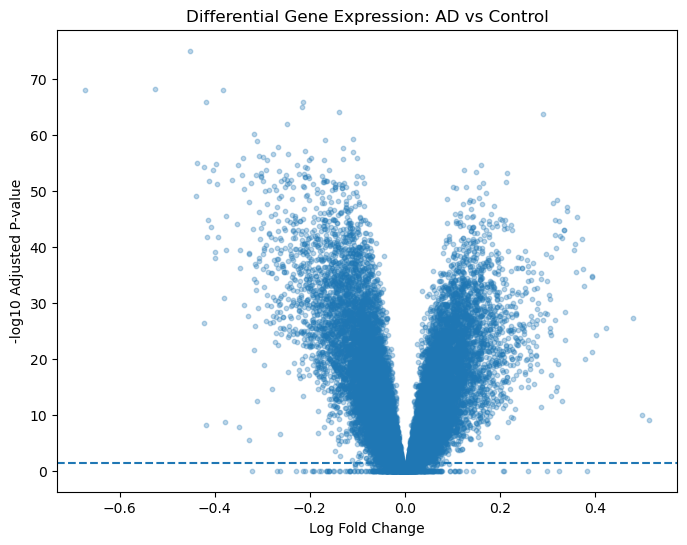

In [20]:
import matplotlib.pyplot as plt

dge_plot = dge[dge["pval_adj"] > 0]

plt.figure(figsize=(8,6))
plt.scatter(
    dge_plot["logFC"],
    -np.log10(dge_plot["pval_adj"]),
    alpha=0.3,
    s=10
)

plt.axhline(-np.log10(0.05), linestyle="--")
plt.xlabel("Log Fold Change")
plt.ylabel("-log10 Adjusted P-value")
plt.title("Differential Gene Expression: AD vs Control")
plt.show()


In [ ]:
#verification

In [21]:
len(dge)


39280

In [22]:
-np.log10(0.05)


1.3010299956639813

In [23]:
sig_genes = dge[dge["pval_adj"] < 0.05]

sig_genes["pval_adj"].max()


0.04998698308965471

In [24]:
(-np.log10(sig_genes["pval_adj"])).min()


1.3011430738305914

In [25]:
dge.sort_values("pval_adj").head()


,gene,logFC,pval,pval_adj
ID_REF,,,,
10026391091,10026391091,-0.452908,2.584970e-80,1.015376e-75
10025931577,10025931577,-0.525636,3.091784e-73,6.072263e-69
10025911097,10025911097,-0.383102,6.944094e-73,9.092134e-69
10023815322,10023815322,-0.672245,1.129595e-72,1.109262e-68
10023811346,10023811346,-0.214076,1.697105e-70,1.333246e-66


In [26]:
sig_genes = dge[
    (dge["pval_adj"] < 0.05) &
    (dge["logFC"].abs() > 0.3)
].copy()

sig_genes.shape


(106, 4)

In [27]:
sig_genes.head()


,gene,logFC,pval,pval_adj
ID_REF,,,,
10023804954,10023804954,0.480211,3.050878e-29,5.361901e-28
10023804956,10023804956,-0.363758,1.558444e-55,1.003536e-52
10023805853,10023805853,0.393016,3.390654e-37,1.476551e-35
10023806267,10023806267,0.310509,6.169175e-51,1.768797e-48
10023807541,10023807541,-0.354082,4.848218e-47,7.934916e-45


In [28]:
import os
os.makedirs("../results", exist_ok=True)

sig_genes.to_csv("../results/significant_genes.csv", index=False)
